# Bayesian Optimisation of starting Gaussian Process hyperparameters

In [2]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [1]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

Gaussian Process Regression

In [5]:
import gpflow
import tensorflow as tf

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6682909200786859820]

In [7]:
from gpflow.utilities import print_summary

In [8]:
gpflow.config.set_default_summary_fmt("notebook")

Input scaler:

In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.exceptions import NotFittedError

Bayesian optimisation based on gaussian processes:

In [10]:
import trieste

## Load previously exported data

In [11]:
#dict_cols = pickle.load(open(Path("dict_cols.pkl"), 'rb'))
dfs_train = pickle.load(open(Path("dfs_train.pkl"), 'rb'))
dfs_test = pickle.load(open(Path("dfs_test.pkl"), 'rb'))

In [45]:
df = pd.read_csv("../Simulink/Exp1_table.csv")
df.rename(columns = {'Power': 'SimulatedHeat'}, inplace = True)

In [14]:
train_exps = ['Exp1', 'Exp3', 'Exp5', 'Exp6']
test_exps = ['Exp2', 'Exp4', 'Exp7']

In [15]:
t_cols = ['time_h', 'time_m']
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [16]:
t_lags = 1
w_lags = 0
u_lags = 2
y_lags = 3

In [17]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

Create the scaler and set up input data scaling:

In [18]:
scaler = MinMaxScaler(feature_range = (-1, 1))

In [19]:
def get_scaled_df(df, dict_cols, scaler):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_local = df[t_list + w_list + u_list + y_list]
    df_scaled = df_local.to_numpy()
    
    try:
        df_scaled = scaler.transform(df_scaled)
    except NotFittedError:
        df_scaled = scaler.fit_transform(df_scaled)
        
    df_scaled = pd.DataFrame(df_scaled, index = df_local.index, columns = df_local.columns)
    
    return df_scaled

In [20]:
df_train = pd.concat(dfs_train)

Condition number of the raw input data:

In [21]:
np.linalg.cond(df_train.to_numpy())

279119.2189692174

Fit the scaler and scale the data:

In [22]:
df_train_sc = get_scaled_df(df_train, dict_cols, scaler)

In [23]:
pickle.dump(scaler, open(Path("scaler.pkl"), 'wb'))

Check the condition number of the input data:

In [24]:
np.linalg.cond(df_train_sc.to_numpy())

4.482732755981847

NOTE: Condition number of scaled data is much smaller. This makes sense.

Scale the data for each experiment individually. Used for validation graphs:

In [27]:
dfs_train_sc = []
dfs_test_sc = []
for df in dfs_train:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_train_sc.append(df_sc)
    
for df in dfs_test:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_test_sc.append(df_sc)

array([[<AxesSubplot:title={'center':'SolRad'}>,
        <AxesSubplot:title={'center':'OutsideTemp'}>],
       [<AxesSubplot:title={'center':'SimulatedHeat'}>,
        <AxesSubplot:title={'center':'SimulatedTemp'}>]], dtype=object)

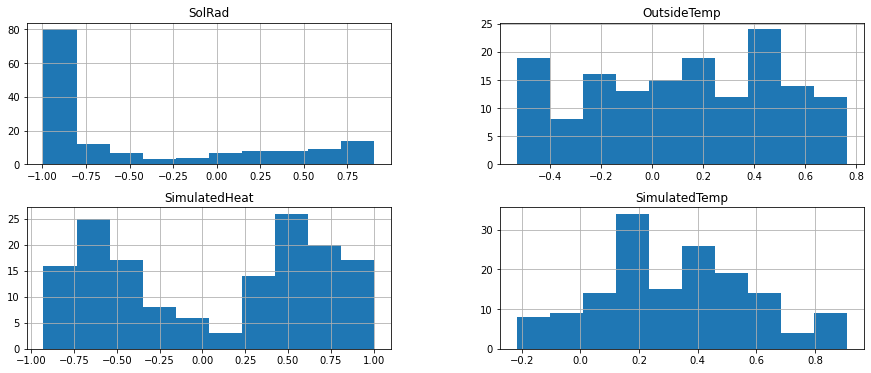

In [35]:
dfs_test_sc[0].hist()

Set up the function which generated the GPR input matrix from the experimental data (including all autoregressive inputs, etc.):

In [24]:
def data_to_gpr(df, dict_cols):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_gpr = df[t_list + w_list + u_list + y_list].copy()
    
    for lags, names in dict_cols.values():
        for name in names:
            col_idx = df_gpr.columns.get_loc(name)
            for lag in range(1, lags + 1):
                df_gpr.insert(col_idx + lag, f"{name}_{lag}", df_gpr.loc[:, name].shift(lag))

    df_gpr.dropna(inplace = True)
    
    return df_gpr

In [25]:
dfs_gpr_train = []
for df_sc in dfs_train_sc:
    dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
df_gpr_train = pd.concat(dfs_gpr_train)
df_gpr_train.head()

,SolRad,OutsideTemp,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,,,
2017-06-01 20:45:00+02:00,-0.970807,0.058824,0.438090,0.438090,0.438090,0.248081,0.233535,0.214339,0.153839
2017-06-01 21:00:00+02:00,-0.980063,0.019608,0.438090,0.438090,0.438090,0.216876,0.248081,0.233535,0.214339
2017-06-01 21:15:00+02:00,-0.989906,-0.058824,-0.470064,0.438090,0.438090,0.062767,0.216876,0.248081,0.233535
2017-06-01 21:30:00+02:00,-0.991909,-0.058824,-0.470064,-0.470064,0.438090,0.091034,0.062767,0.216876,0.248081
2017-06-01 21:45:00+02:00,-0.992483,-0.058824,0.577419,-0.470064,-0.470064,0.203306,0.091034,0.062767,0.216876


In [26]:
dfs_gpr_test = []
for df_sc in dfs_test_sc:
    dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

In [27]:
#df_gpr_train = df_gpr_train.sample(n = 500)

In [28]:
df_input_train = df_gpr_train.drop(columns = dict_cols['u'][1] + dict_cols['y'][1])
df_output_train = df_gpr_train[dict_cols['y'][1]]

np_input_train = df_input_train.to_numpy()
np_output_train = df_output_train.to_numpy().reshape(-1, 1)

In [29]:
data_train = (np_input_train, np_output_train)
pickle.dump(data_train, open(Path("data_train.pkl"), 'wb'))

In [30]:
df_input_train.head()

,SolRad,OutsideTemp,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,
2017-06-01 20:45:00+02:00,-0.970807,0.058824,0.438090,0.438090,0.233535,0.214339,0.153839
2017-06-01 21:00:00+02:00,-0.980063,0.019608,0.438090,0.438090,0.248081,0.233535,0.214339
2017-06-01 21:15:00+02:00,-0.989906,-0.058824,0.438090,0.438090,0.216876,0.248081,0.233535
2017-06-01 21:30:00+02:00,-0.991909,-0.058824,-0.470064,0.438090,0.062767,0.216876,0.248081
2017-06-01 21:45:00+02:00,-0.992483,-0.058824,-0.470064,-0.470064,0.091034,0.062767,0.216876


In [31]:
import scipy.io

In [42]:
scipy.io.savemat(
    f"dfs_datasets.mat",
    {'train0': dfs_train_sc[0][t_cols + w_cols + u_cols + y_cols].to_numpy(),
     'train1': dfs_train_sc[1][t_cols + w_cols + u_cols + y_cols].to_numpy(),
     'train2': dfs_train_sc[2][t_cols + w_cols + u_cols + y_cols].to_numpy(),
     'train3': dfs_train_sc[3][t_cols + w_cols + u_cols + y_cols].to_numpy(),
     'test0': dfs_test_sc[0][t_cols + w_cols + u_cols + y_cols].to_numpy(),
     'test1': dfs_test_sc[1][t_cols + w_cols + u_cols + y_cols].to_numpy(),
     'test2': dfs_test_sc[2][t_cols + w_cols + u_cols + y_cols].to_numpy(),
     'cols': t_cols + w_cols + u_cols + y_cols, 
     })

In [31]:
np_export_train = df_gpr_train.to_numpy()
np_export_test = dfs_gpr_test[0].to_numpy()
scipy.io.savemat(f"gpr_export.mat", {'train': np_export_train, 'cols': df_gpr_train.columns.to_list(), 'test': np_export_test})

In [32]:
## Define Kernel

In [33]:
nb_dims = np_input_train.shape[1]
rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
nb_rational_dims = len(rational_dims)
squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
nb_squared_dims = len(squared_dims)

In [34]:
print(f"rational: {nb_rational_dims}")
print(f"squared: {nb_squared_dims}")

rational: 0
squared: 7


In [35]:
squared_l = np.linspace(10, 10, nb_squared_dims)
rational_l = np.linspace(10, 10, nb_rational_dims)

In [36]:
#variance = tf.math.reduce_variance(np_input_train)

In [37]:
variance = 1

In [38]:
k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k1 = gpflow.kernels.Constant(variance = variance)
k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)
k3 = gpflow.kernels.Periodic(k2)

In [40]:
k4 = gpflow.kernels.Linear(variance = [1]*nb_dims)

In [41]:
k = (k0 + k1) * k2
k = k4
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Linear.variance,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."


## Compile Model

In [44]:
m = gpflow.models.GPR(
    data = data_train, 
    kernel = k, 
    mean_function = None,
    )
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [45]:
#m.likelihood.variance.assign(0.5)

In [46]:
#gpflow.set_trainable(m.likelihood.variance, False)

## Train Model

In [47]:
opt = gpflow.optimizers.Scipy()

In [48]:
from datetime import datetime

In [49]:
start_time = datetime.now()
opt.minimize(m.training_loss, m.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(m)

Finished fitting in 0:00:04.616717


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,"(7,)",float64,"[1.88404972e-05, 2.35199453e-04, 4.70785497e-02..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0011367938506279384


Export model parameters:

In [51]:
m_params = gpflow.utilities.parameter_dict(m)
pickle.dump(m_params, open(Path(Path.cwd(), 'gp_params.pkl'), 'wb'))

In [52]:
pickle.dump(m, open(Path(Path.cwd(), 'gp_model.pkl'), 'wb'))

In [69]:
m = pickle.load(open(Path("gp_model.pkl"), 'rb'))

## Evaluate performance on training data

In [70]:
nb_plts = len(dfs_gpr_train)

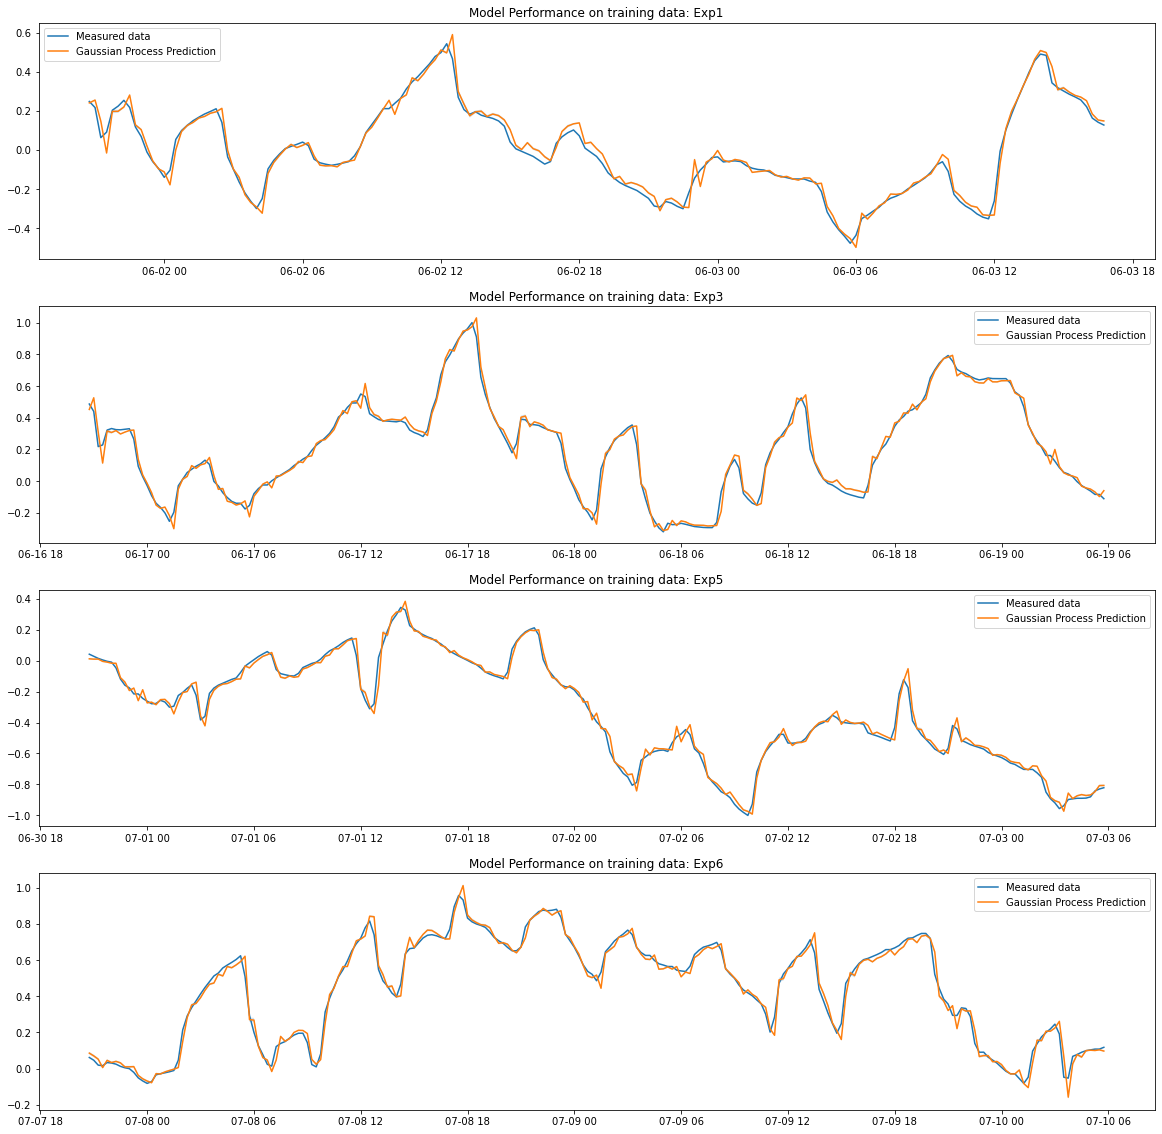

In [71]:
plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.show()

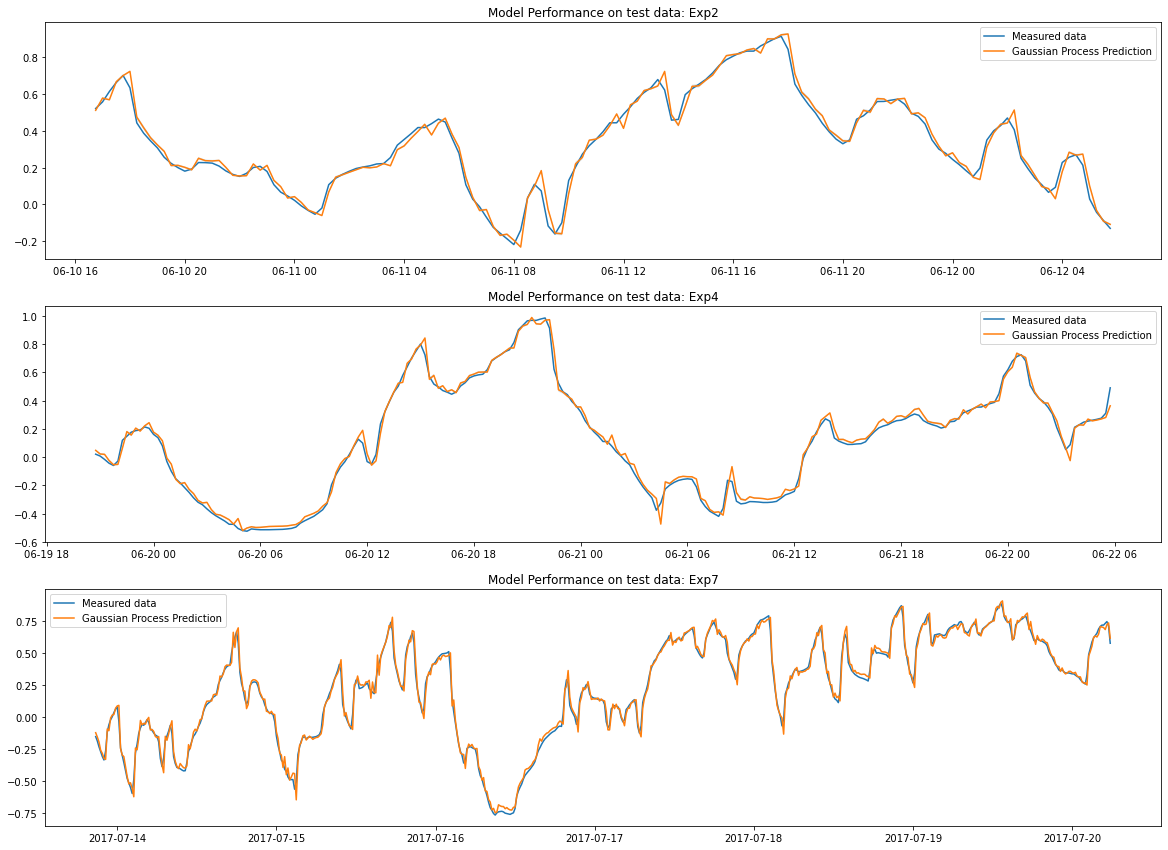

In [72]:
plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.show()

In [73]:
np.linalg.cond(np_input_train)

64.26510397973743

In [74]:
np.linalg.cond(k(np_input_train))

1.2399082841705338e+22

In [64]:
ylag1_idx = df_iter.columns.to_list().index(f"{dict_cols['y'][1][0]}_1")
ylags = dict_cols['y'][0]

In [65]:
#@tf.function
def multistep_prediction(m, tf_input):
    N_pred = tf_input.shape[0]
    for idxx in range(N_pred - 1):
        mean,_ = m.predict_f(tf.reshape(tf_input[idxx, :], (1, -1)))
        tf_input[idxx+1, ylag1_idx].assign(mean[0,0])
        tf_input[idxx + 1, ylag1_idx + 1 : ylag1_idx + ylags].assign(tf_input[idxx, ylag1_idx : ylag1_idx + ylags - 1])
    mean, _ = m.predict_f(tf_input)
    return mean

In [66]:
#@tf.function
def multistep_error(m, data):
    tf_input = data[0]
    tf_targets = data[1]
    tf_outputs = multistep_prediction(m, tf_input)
    err = tf.sqrt(tf.reduce_mean((tf_targets - tf_outputs)**2))
    return err

In [67]:
def m_obj_value(m):

    tf_errs = 0
    tf_vars = 0
    tf_multi_err = 0
    for idx, df_iter in enumerate(dfs_gpr_test):
        df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
        df_output_iter = df_iter[dict_cols['y'][1]]
        np_input_iter = df_input_iter.to_numpy()
        np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
        
        mean, var = m.predict_f(np_input_iter)

        err_iter = tf.reshape(mean - np_output_iter, (-1,))
        tf_errs += tf.tensordot(err_iter, err_iter, 1)

        var_iter = tf.reshape(var,(-1,))
        tf_vars += tf.tensordot(var_iter, var_iter, 1)
        
        # Get n random points at which to compute multistep error
        n_multi = 10
        idx_multi = np.random.choice(len(df_iter), n_multi)
        for idxx in idx_multi:
            tf_input_multi = tf.Variable(df_input_iter.iloc[idx:(idx + N_pred)])
            tf_output_multi = tf.Variable(df_output_iter.iloc[idx:(idx + N_pred)])
            tf_data_multi = (tf_input_multi, tf_output_multi)
            tf_multi_err += multistep_error(m, tf_data_multi)
            


    obj = 5 * tf_errs + 0 * tf_vars + 1 * tf_multi_err


    return obj

In [68]:
def get_gp_from_hyperparams(tf_params):

    print("Training a GP")
    squared_l  = tf_params[0]
    variance = tf_params[1]

    k0 = gpflow.kernels.SquaredExponential(lengthscales = [squared_l]*np_input_train.shape[1], variance = variance)

    k = k0

    m = gpflow.models.GPR(
    data = (np_input_train, np_output_train), 
    kernel = k, 
    mean_function = None
    )

    opt = gpflow.optimizers.Scipy()

    opt.minimize(m.training_loss, m.trainable_variables)

    return m

In [69]:
np_input_train.shape[1]

7

In [70]:
m_test = get_gp_from_hyperparams([0.1, 1])

Training a GP


In [50]:
gpflow.utilities.parameter_dict(m)

{'.kernel.kernels[0].kernels[0].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=17.68127119263729>,
 '.kernel.kernels[0].kernels[0].lengthscales': <Parameter: dtype=float64, shape=[7], fn="softplus", numpy=
 array([5682.89228974, 2927.70798971,  123.90443445,  170.87216202,
          12.24082499,   18.2855289 , 1652.39401848])>,
 '.kernel.kernels[0].kernels[1].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=4.089199799344012e-08>,
 '.kernel.kernels[1].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=17.560183988120716>,
 '.kernel.kernels[1].lengthscales': <Parameter: dtype=float64, shape=[2], fn="softplus", numpy=array([6013.93882777, 5912.03412562])>,
 '.kernel.kernels[1].alpha': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.7367603383166306>,
 '.likelihood.variance': <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.05000000000000001>}

In [762]:
def gp_cost(tf_params):

    try:
        m = get_gp_from_hyperparams(tf_params)
        obj = m_obj_value(m)
    except tf.errors.InvalidArgumentError:
        obj = np.nan
    
    if obj == np.inf or obj > 1000:
        obj = np.nan

    return obj

In [763]:
def gp_cost_map(tf_params):
    obj = tf.map_fn(gp_cost, tf_params)
    obj = tf.reshape(obj, (-1, 1))
    return obj

In [53]:
bl = [100] * nb_rational_dims + [1.0] * nb_squared_dims
bu = [250] * nb_rational_dims + [2.5] * nb_squared_dims

In [839]:
bl = [0.1, 0.1]
bu = [10, 10]

In [840]:
search_space = trieste.space.Box(bl, bu)

In [842]:
init_X = search_space.sample(25)

### Optimization with failure regions

In [843]:
OBJECTIVE = "OBJECTIVE"
FAILURE = "FAILURE"

def gp_observer(x):
    try:
        y = gp_cost_map(x)
    except:
        y = np.nan
    print(y)
    mask = np.isfinite(y).reshape(-1)
    return {
        OBJECTIVE: trieste.data.Dataset(x[mask], y[mask]),
        FAILURE: trieste.data.Dataset(x, tf.cast(np.isfinite(y), tf.float64))
    }

In [844]:
initial_data = gp_observer(init_X)

Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
tf.Tensor(
[[49.68307447]
 [48.17950289]
 [52.46541048]
 [52.67746495]
 [48.04459403]
 [        nan]
 [52.87997034]
 [48.88740409]
 [52.81439254]
 [        nan]
 [52.30934785]
 [39.64154545]
 [        nan]
 [48.25223144]
 [52.57604174]
 [        nan]
 [47.52992461]
 [49.17097817]
 [52.07901221]
 [49.65099421]
 [        nan]
 [        nan]
 [30.41374006]
 [        nan]
 [51.19509676]], shape=(25, 1), dtype=float64)


In [845]:
def create_regression_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2]*2)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        variance=100.0, lengthscales=[0.2]*2
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    gpflow.set_trainable(vgp.kernel.variance, False)
    return vgp


regression_model = create_regression_model(initial_data[OBJECTIVE])
classification_model = create_classification_model(initial_data[FAILURE])

In [846]:
class NatGradTrainedVGP(trieste.models.VariationalGaussianProcess):
    def optimize(self, dataset):
        gpflow.set_trainable(self.model.q_mu, False)
        gpflow.set_trainable(self.model.q_sqrt, False)
        variational_params = [(self.model.q_mu, self.model.q_sqrt)]
        adam_opt = tf.optimizers.Adam(1e-3)
        natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)

        for step in range(50):
            loss = self.model.training_loss
            natgrad_opt.minimize(loss, variational_params)
            adam_opt.minimize(loss, self.model.trainable_variables)

In [847]:
from typing import Dict

models: Dict[str, trieste.models.ModelSpec] = {
    OBJECTIVE: {
        "model": regression_model,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)},
        },
    },
    FAILURE: NatGradTrainedVGP(classification_model),
}

In [848]:
class ProbabilityOfValidity(trieste.acquisition.SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, dataset, model):
        return lambda at: trieste.acquisition.lower_confidence_bound(model, 0.0, at)

ei = trieste.acquisition.ExpectedImprovement()
pov = ProbabilityOfValidity()
acq_fn = trieste.acquisition.Product(ei.using(OBJECTIVE), pov.using(FAILURE))
rule = trieste.acquisition.rule.EfficientGlobalOptimization(acq_fn)

In [849]:
nb_optimization_steps = 50

In [850]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(gp_observer, search_space)

In [851]:
result = bo.optimize(nb_optimization_steps, initial_data, models, rule)

Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[48.49316661]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[52.73941858]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[52.53105]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[52.81369458]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[52.80402914]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[48.96366872]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([

In [852]:
result = result.final_result.unwrap()

arg_min_idx = tf.squeeze(tf.argmin(result.datasets[OBJECTIVE].observations, axis=0))
print(f"query point: {result.datasets[OBJECTIVE].query_points[arg_min_idx, :]}")

query point: [5.40174621 5.07058858]


In [853]:
best_params = result.datasets[OBJECTIVE].query_points[arg_min_idx, :]

In [854]:
m_best = get_gp_from_hyperparams(best_params)

Training a GP


In [855]:
#m_best = m

In [83]:
gpflow.utilities.parameter_dict(m_best)

{'.kernel.variance': <Parameter: dtype=float64, shape=[7], fn="softplus", numpy=
 array([1.88404972e-05, 2.35199453e-04, 4.70785497e-02, 2.67713883e-02,
        7.46741281e+00, 3.53745465e+00, 2.97911475e-02])>,
 '.likelihood.variance': <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.0011367938506279384>}

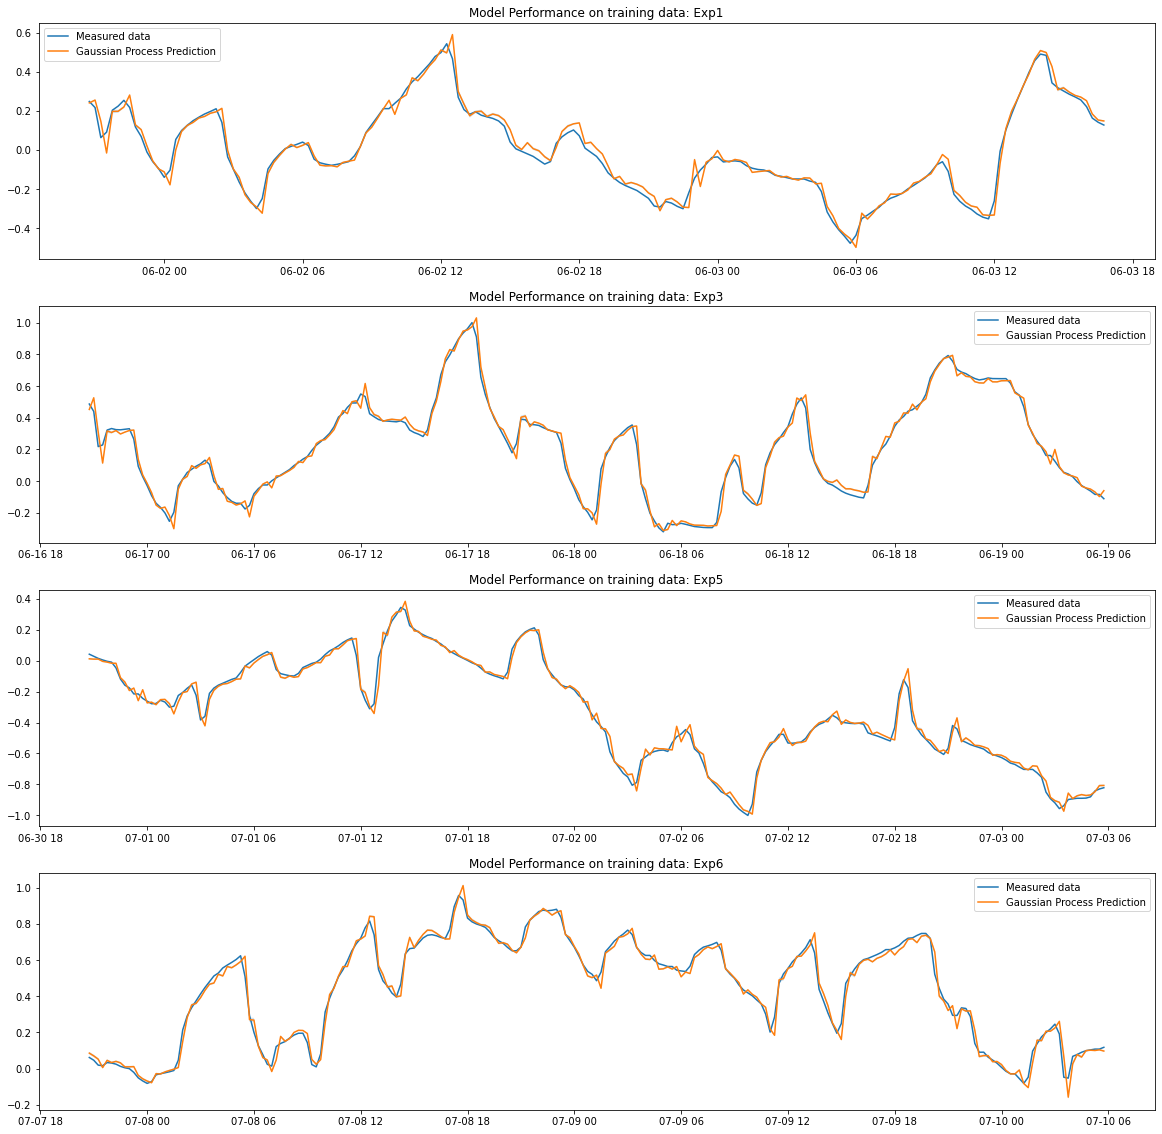

In [81]:
nb_plts = len(dfs_train)

plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m_best.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.savefig(f"Performance_train_exps.png")

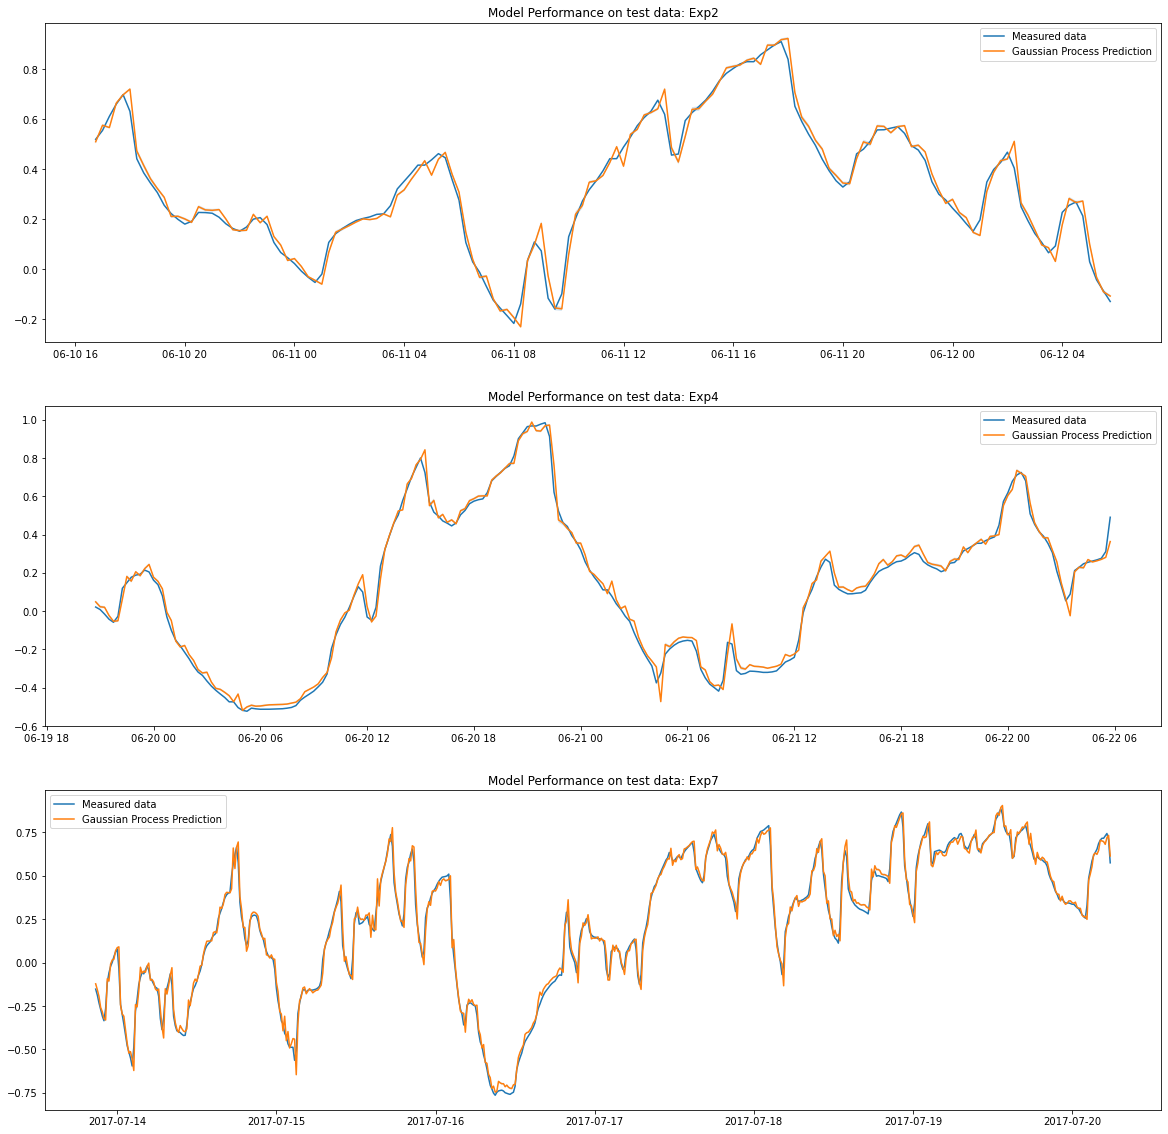

In [82]:
nb_plts = len(dfs_test)

plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m_best.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.savefig(f"Performance_test_exps.png")

In [825]:
np.log10(np.linalg.cond(m_best.kernel(np_input_train)))

21.182911210003116

In [826]:
m_obj_value(m_best)

<tf.Tensor: shape=(), dtype=float64, numpy=15.182775154614564>

In [827]:
df_input_train

,SolRad,OutsideTemp,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,
2017-06-01 20:45:00+02:00,-0.970807,0.058824,0.438090,0.438090,0.233535,0.214339,0.153839
2017-06-01 21:00:00+02:00,-0.980063,0.019608,0.438090,0.438090,0.248081,0.233535,0.214339
2017-06-01 21:15:00+02:00,-0.989906,-0.058824,0.438090,0.438090,0.216876,0.248081,0.233535
2017-06-01 21:30:00+02:00,-0.991909,-0.058824,-0.470064,0.438090,0.062767,0.216876,0.248081
2017-06-01 21:45:00+02:00,-0.992483,-0.058824,-0.470064,-0.470064,0.091034,0.062767,0.216876
...,...,...,...,...,...,...,...
2017-07-10 04:45:00+02:00,-1.000000,-0.411765,0.423283,0.423283,0.090031,0.077547,0.067484
2017-07-10 05:00:00+02:00,-1.000000,-0.411765,0.423283,0.423283,0.098815,0.090031,0.077547
2017-07-10 05:15:00+02:00,-1.000000,-0.411765,0.423283,0.423283,0.103469,0.098815,0.090031


## Multistep prediction

In [72]:
df_input = dfs_gpr_train[0].drop(columns = dict_cols['u'][1] + dict_cols['y'][1])
df_output = dfs_gpr_train[0][dict_cols['y'][1]]

In [73]:
start_idx = 25
nb_predictions = 10
N_pred = 8

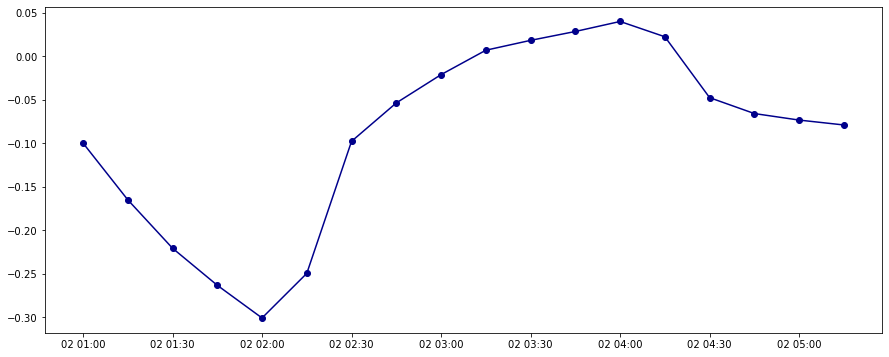

In [74]:
plt.figure()
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')

In [75]:
df_iter

,SolRad,OutsideTemp,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,,,
2017-07-13 20:45:00+02:00,-0.906144,0.294118,-0.906566,-0.906566,-0.906566,-0.152825,-0.120327,-0.078555,0.065348
2017-07-13 21:00:00+02:00,-0.971051,0.254902,-0.906566,-0.906566,-0.906566,-0.187286,-0.152825,-0.120327,-0.078555
2017-07-13 21:15:00+02:00,-0.986502,0.176471,-0.906566,-0.906566,-0.906566,-0.232325,-0.187286,-0.152825,-0.120327
2017-07-13 21:30:00+02:00,-0.990599,0.176471,-0.906566,-0.906566,-0.906566,-0.270313,-0.232325,-0.187286,-0.152825
2017-07-13 21:45:00+02:00,-0.991623,0.176471,-0.906566,-0.906566,-0.906566,-0.307765,-0.270313,-0.232325,-0.187286
...,...,...,...,...,...,...,...,...,...
2017-07-20 04:45:00+02:00,-0.993065,0.058824,0.969031,0.969031,0.969031,0.716151,0.716151,0.705869,0.685924
2017-07-20 05:00:00+02:00,-0.993245,0.058824,0.969031,0.969031,0.969031,0.729486,0.716151,0.716151,0.705869
2017-07-20 05:15:00+02:00,-0.993307,0.058824,0.969031,0.969031,0.969031,0.743645,0.729486,0.716151,0.716151


In [76]:
m_best = m

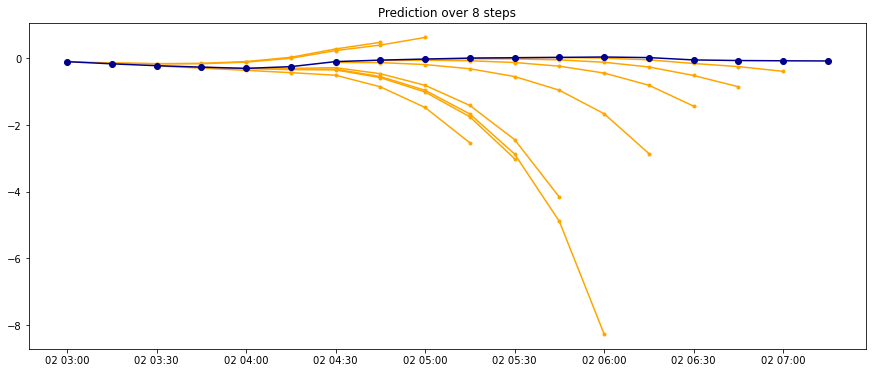

In [77]:
plt.figure()

y_name = dict_cols['y'][1][0]
for idx in range(start_idx, start_idx + nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        idx_old = df_iter.index[idxx]
        idx_new = df_iter.index[idxx+1]
        mean, var = m_best.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
        df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
        for lag in range(2, dict_cols['y'][0] + 1):
            df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]
        
    mean_iter, var_iter = m_best.predict_f(df_iter.to_numpy())
    plt.plot(df_iter.index, mean_iter.numpy(), '.-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.title(f"Prediction over {N_pred} steps")
plt.savefig(f"prediction_{N_pred}_steps.png")

In [147]:
m.training_loss

<bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.gpr.GPR object at 0x7fe4481501c0>>

In [152]:
tf_test = tf.Variable(np.ones((3, 3)))

In [296]:
%%timeit
df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
for idxx in range(N_pred - 1):
    idx_old = df_iter.index[idxx]
    idx_new = df_iter.index[idxx+1]
    mean, var = m_best.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
    df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
    for lag in range(2, dict_cols['y'][0] + 1):
        df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]

2.79 s ± 76.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [407]:
N_pred = 15

In [ ]:
data_in = df_input.iloc[idx:(idx + N_pred)].copy()
data_out = df_output.iloc[idx:(idx + N_pred)].copy()

In [416]:
ylag1_idx = df_iter.columns.to_list().index(f"{dict_cols['y'][1][0]}_1")
ylags = dict_cols['y'][0]
tf_input = tf.Variable(data_in)

In [417]:
@tf.function
def multistep_prediction(tf_input):
    N_pred = tf_input.shape[0]
    for idxx in range(N_pred - 1):
        mean,_ = m.predict_f(tf.reshape(tf_input[idxx, :], (1, -1)))
        tf_input[idxx+1, ylag1_idx].assign(mean[0,0])
        tf_input[idxx + 1, ylag1_idx + 1 : ylag1_idx + ylags].assign(tf_input[idxx, ylag1_idx : ylag1_idx + ylags - 1])
    mean, _ = m.predict_f(tf_input)
    return mean

In [418]:
model_out = multistep_prediction(tf.Variable(data_in))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpusoeex0r.py, line 20)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpusoeex0r.py, line 20)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [419]:
#@tf.function
def multistep_error(data):
    tf_input = data[0]
    tf_targets = data[1]
    tf_outputs = multistep_prediction(tf_input)
    err = tf.sqrt(tf.reduce_mean((tf_targets - tf_outputs)**2))
    return err

In [ ]:
data = (tf.Variable(data_in), tf.Variable(data_out))

In [428]:
%%timeit
for idx in range(50):
    multistep_error(data)

26.4 s ± 3.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


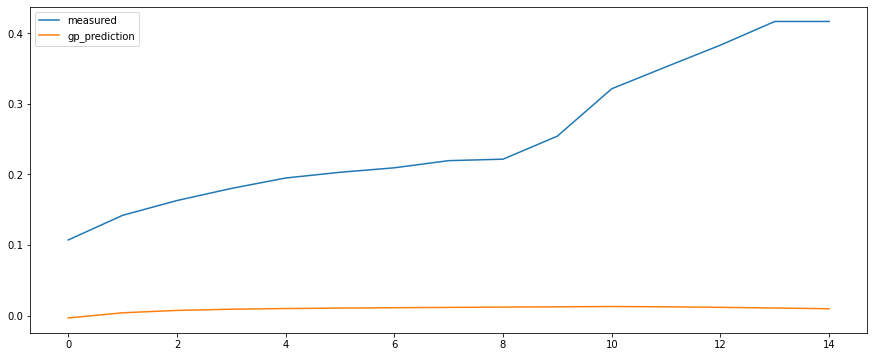

In [423]:
plt.figure()
plt.plot(data_out.to_numpy(), label = 'measured')
plt.plot(model_out, label = 'gp_prediction')
plt.legend()

In [440]:
rational_l = 1
squared_l  = 1

variance = 1

k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k1 = gpflow.kernels.Constant(variance = variance)
k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)

k = (k0 + k1) * k2

m = gpflow.models.GPR(
data = (np_input_train, np_output_train), 
kernel = k, 
mean_function = None
)

opt = gpflow.optimizers.Scipy()

opt.minimize(m.training_loss, m.trainable_variables)

InvalidArgumentError:  Input matrix is not invertible.
	 [[node gradient_tape/triangular_solve/MatrixTriangularSolve (defined at /usr/lib/python3.9/site-packages/gpflow/optimizers/scipy.py:173) ]] [Op:__inference__tf_eval_1886136]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/triangular_solve/MatrixTriangularSolve:
 Cholesky (defined at /usr/lib/python3.9/site-packages/gpflow/models/gpr.py:87)

Function call stack:
_tf_eval


In [567]:
class MultistepGP(gpflow.models.GPR):
    
    def __init__(self, data):
        
        rational_l = 1
        squared_l  = 1

        variance = 1

        k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
        k1 = gpflow.kernels.Constant(variance = variance)
        k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)

        k = (k0 + k1) * k2
        
        self.train_data = tf.Variable(data[0][:10]), tf.Variable(data[1][:10])

        
        super().__init__(data = data, kernel = k, mean_function = None)

"""
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def multistep_prediction(self, tf_input):
        N_pred = tf_input.shape[0]
        for idxx in range(N_pred - 1):
            mean,_ = self.predict_f(tf.reshape(tf_input[idxx, :], (1, -1)))
            tf_input[idxx+1, ylag1_idx].assign(mean[0,0])
            tf_input[idxx + 1, ylag1_idx + 1 : ylag1_idx + ylags].assign(tf_input[idxx, ylag1_idx : ylag1_idx + ylags - 1])
        mean, _ = self.predict_f(tf_input)
        return mean
    
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def multistep_error(self,data):
        tf_inputs, tf_targets = data
        tf_outputs = self.multistep_prediction(tf_inputs)
        err = tf.sqrt(tf.reduce_mean((tf_targets - tf_outputs)**2))
        return err
        
    def multistep_training_loss(self):
        return self.multistep_error(self.train_data)
"""
    

In [568]:
test_gp = MultistepGP(data)
test_gp

name,class,transform,prior,trainable,shape,dtype,value
MultistepGP.train_data[0],ResourceVariable,,,True,"(10, 9)",float64,"[[2.22613378e-03, -1.87413538e+00, -9.95142923e-01..."
MultistepGP.train_data[1],ResourceVariable,,,True,"(10, 1)",float64,[[-4.72829156e-17...
MultistepGP.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
MultistepGP.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
MultistepGP.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
MultistepGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
MultistepGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
MultistepGP.kernel.kernels[1].alpha,Parameter,Softplus,,True,(),float64,1.0
MultistepGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
MultistepGP.data[0],ResourceVariable,,,True,"(15, 9)",float64,"[[2.22613378e-03, -1.87413538e+00, -9.95142923e-01..."


In [571]:
test_gp.training_loss

<bound method InternalDataTrainingLossMixin.training_loss of <__main__.MultistepGP object at 0x7fe3e7e50400>>

In [572]:
opt = gpflow.optimizers.Scipy()

opt.minimize(test_gp.training_loss, test_gp.trainable_variables)

ValueError: in user code:

    /usr/lib/python3.9/site-packages/gpflow/optimizers/scipy.py:107 _tf_eval  *
        return loss, cls.pack_tensors(grads)
    /usr/lib/python3.9/site-packages/gpflow/optimizers/scipy.py:139 pack_tensors  *
        flats = [tf.reshape(tensor, (-1,)) for tensor in tensors]
    /usr/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:195 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    /usr/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py:8377 reshape
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /usr/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:538 _apply_op_helper
        raise ValueError(

    ValueError: Tried to convert 'tensor' to a tensor and failed. Error: None values not supported.
